In [3]:
# API Key: 5F7QGJQDS6L1H1RS
# Stock API: https://www.alphavantage.co/documentation/
# API Data Endpoint: https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&outputsize=full&datatype=csv&apikey=

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ml_utilities as utils

stockprices = pd.read_csv("daily_AAPL2.csv", index_col="Date").sort_index()
test_ratio = 0.2
training_ratio = 1 - test_ratio
train_size = int(training_ratio * len(stockprices))
test_size = int(test_ratio * len(stockprices))
train = stockprices[:train_size][["Close"]]
test = stockprices[train_size:][["Close"]]

window_size = 50
window_var = f"{window_size}day"

print(f"train_size: {train_size}")
print(f"test_size: {test_size}")


train_size: 4896
test_size: 1224


In [4]:
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.layers import LSTM, Dense, Input
from keras.models import Model

layer_units = 50
optimizer = "adam"
cur_epochs = 15
cur_batch_size = 20

scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockprices[["Close"]])
scaled_data_train = scaled_data[: train.shape[0]]

X_train, y_train = utils.extract_seqX_outcomeY(scaled_data_train, window_size, window_size)



In [6]:
def Run_LSTM(X_train, layer_units=50):
    inp = Input(shape=(X_train.shape[1], 1))

    x = LSTM(units=layer_units, return_sequences=True)(inp)
    x = LSTM(units=layer_units)(x)
    out = Dense(1, activation="linear")(x)
    model = Model(inp, out)

    # Compile the LSTM neural net
    model.compile(loss="mean_squared_error", optimizer="adam")

    return model


In [7]:

model = Run_LSTM(X_train, layer_units=layer_units)

In [8]:

history = model.fit(
    X_train,
    y_train,
    epochs=cur_epochs,
    batch_size=cur_batch_size,
    verbose=1,
    validation_split=0.1,
    shuffle=True
)

Epoch 1/15
219/219 [==============================] - 5s 14ms/step - loss: 0.0547 - val_loss: 0.0094
Epoch 2/15
219/219 [==============================] - 3s 12ms/step - loss: 0.0163 - val_loss: 0.0015
Epoch 3/15
219/219 [==============================] - 3s 12ms/step - loss: 0.0116 - val_loss: 0.0012
Epoch 4/15
219/219 [==============================] - 3s 12ms/step - loss: 0.0101 - val_loss: 0.0011
Epoch 5/15
219/219 [==============================] - 3s 12ms/step - loss: 0.0078 - val_loss: 0.0010
Epoch 6/15
219/219 [==============================] - 3s 12ms/step - loss: 0.0075 - val_loss: 9.7642e-04
Epoch 7/15
219/219 [==============================] - 3s 12ms/step - loss: 0.0064 - val_loss: 8.8957e-04
Epoch 8/15
219/219 [==============================] - 3s 12ms/step - loss: 0.0064 - val_loss: 8.5401e-04
Epoch 9/15
219/219 [==============================] - 3s 12ms/step - loss: 0.0058 - val_loss: 8.1195e-04
Epoch 10/15
219/219 [==============================] - 3s 12ms/step - loss:

In [9]:
# predict stock prices using past window_size stock prices
def preprocess_testdat(data=stockprices, scaler=scaler, window_size=window_size, test=test):
    raw = data["Close"][len(data) - len(test) - window_size:].values
    raw = np.array(raw).reshape(-1,1)
    raw = scaler.transform(raw)

    X_test = [np.array(raw)[i-window_size:i, 0] for i in range(window_size, raw.shape[0])]
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

X_test = preprocess_testdat()

predicted_price_ = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

# Plot predicted price vs actual closing price
test["Predictions_lstm"] = predicted_price

c:\Users\Christian\anaconda3\envs\ml-env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


39/39 [==============================] - 1s 5ms/step


rmse_lstm: 12.642013143791415
rmse_lstm: 2.6887651656176264


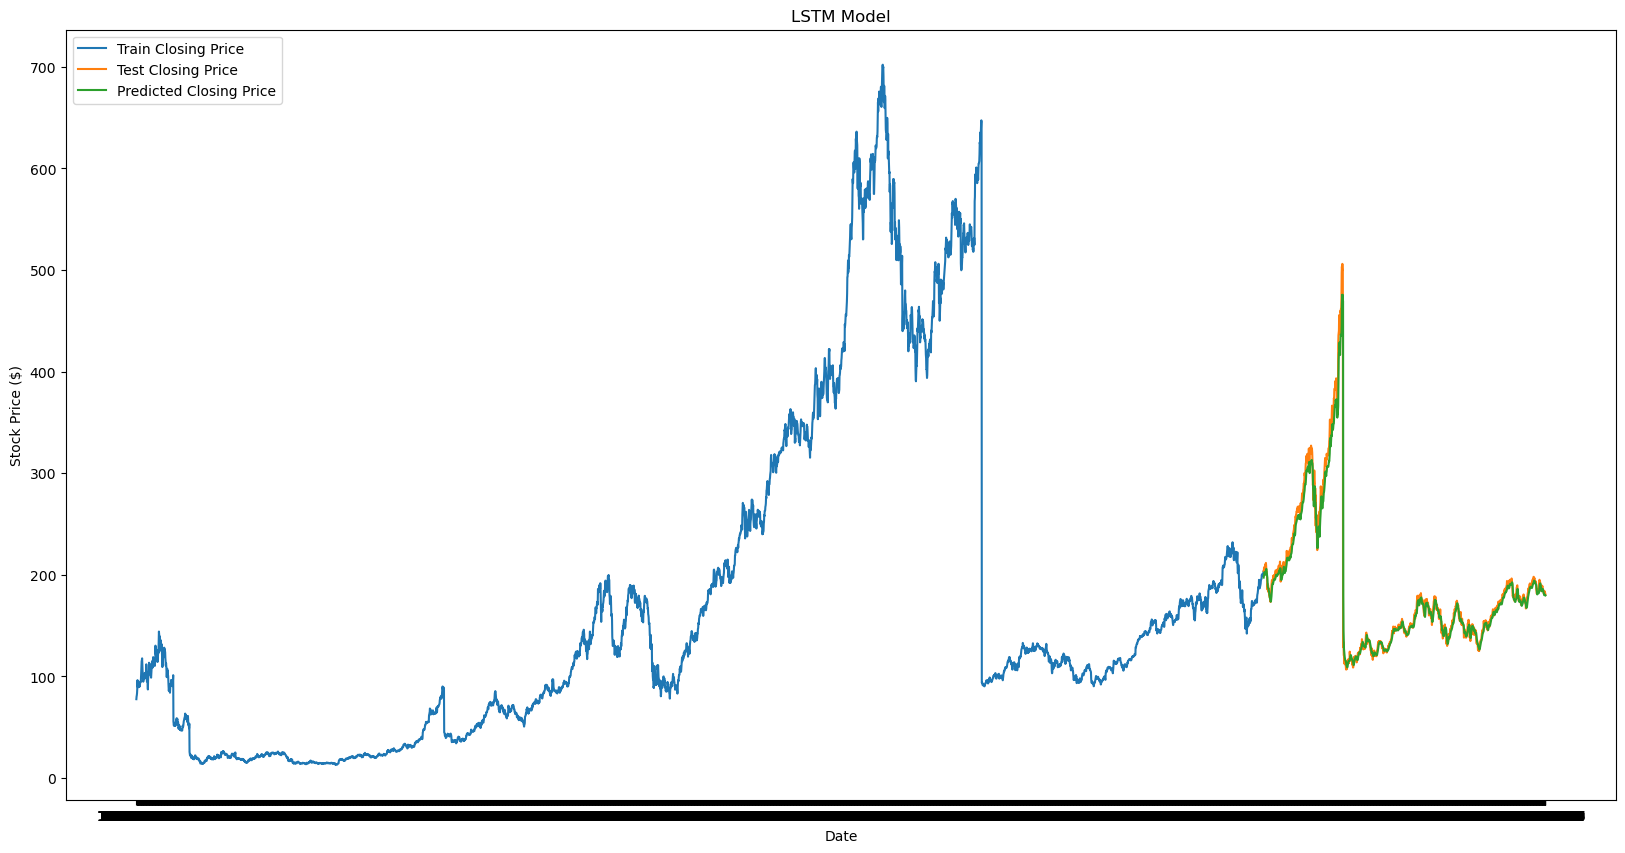

In [11]:
# Evaluate performance
rmse_lstm = utils.calculate_rmse(np.array(test["Close"]), np.array(test["Predictions_lstm"]))
mape_lstm = utils.calculate_mape(np.array(test["Close"]), np.array(test["Predictions_lstm"]))

### Plot prediction and true trends and log to Neptune
def plot_stock_trend_lstm(train, test):
    fig = plt.figure(figsize = (20,10))
    plt.plot(np.asarray(train.index), np.asarray(train["Close"]), label = "Train Closing Price")
    plt.plot(np.asarray(test.index), np.asarray(test["Close"]), label = "Test Closing Price")
    plt.plot(np.asarray(test.index), np.asarray(test["Predictions_lstm"]), label = "Predicted Closing Price")
    plt.title("LSTM Model")
    plt.xlabel("Date")
    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper left")

print(f"rmse_lstm: {rmse_lstm}")
print(f"rmse_lstm: {mape_lstm}")
plot_stock_trend_lstm(train, test)